# Training

This notebook includes an example training loop for the models.

In [60]:
import torch
import os
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

from model.one_model.one_stage_models import ResNet50OneStage
from data.dataset import CheXpertDataset

%load_ext autoreload
%autoreload 2

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots


os.environ['KMP_DUPLICATE_LIB_OK']='True' # To prevent the kernel from dying.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Datasets

In [61]:
# Define parameter dictionary
params_transform = {
    'degree_range': (-15, 15),
    'translate': (0.1, 0.2),
    'scale': (0.2, 1.0),
    'ratio': (0.75, 1.3333333333333333),
    'gaussian_blur_kernel': 3,
    'contrast': (0.75, 1.25),
    'saturation': (0.75, 1.25),
    'brightness': (0.75, 1.25)
}

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.RandomRotation(params_transform['degree_range']),
    transforms.RandomAffine(degrees=params_transform['degree_range'], translate=params_transform['translate']),
    transforms.RandomResizedCrop(size=(224, 224), scale=params_transform['scale'], ratio=params_transform['ratio']),
    transforms.GaussianBlur(kernel_size=params_transform['gaussian_blur_kernel']),
    transforms.ColorJitter(brightness=params_transform['brightness'], contrast=params_transform['contrast'], saturation=params_transform['saturation']),
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

targets = {
            # "sex": 1,
            # "age": 2,
            # "frontal/lateral": 3,
            # "ap/pa": 4,
            # "no_finding": 5,
            # "enlarged_cardiomediastinum": 6,
            # "cardiomegaly": 7,
            # "lung_opacity": 8,
            # "lung_lesion": 9,
            # "edema": 10,
            # "consolidation": 11,
            # "pneumonia": 12,
            # "atelectasis": 13,
            # "pneumothorax": 14,
            # "pleural_effusion": 15,
            # "pleural_other": 16,
            # "fracture": 17,
            "support_devices": 18,
            # add other ones 
        }

train_dataset = CheXpertDataset(
    csv_file="./data/valid.csv", # for debugging
    root_dir="../image_data/",
    targets=targets,
    transform=transform,
)
val_dataset = CheXpertDataset(
    csv_file="./data/valid.csv",
    root_dir="../image_data/",  
    targets=targets,
    transform=val_transform,
)

Labels found: [0 1]
Labels found: [0 1]


Train dataset size: 234
Valid dataset size: 234
Example
[0.]
torch.Size([1, 224, 224])


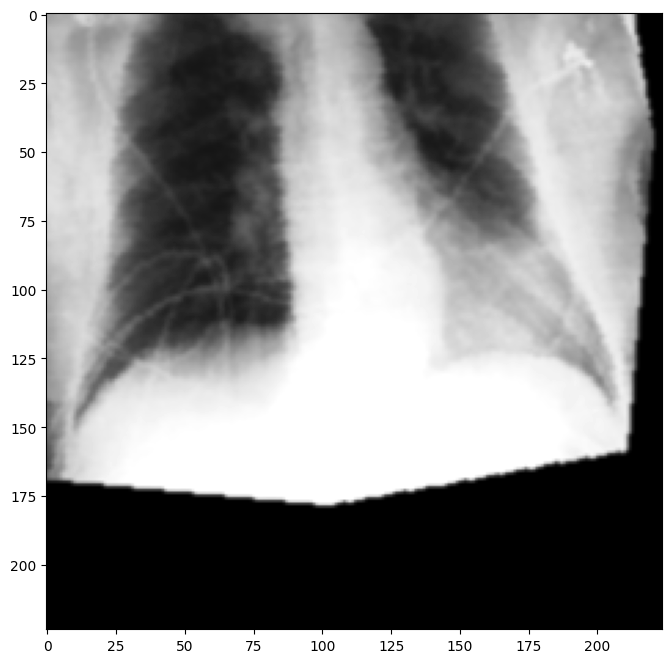

In [62]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Valid dataset size: {len(val_dataset)}")

print("Example")
img, label = train_dataset[0]
print(f"{label}")
print(f"{img.shape}")
img = img.squeeze().numpy()
plt.imshow(img, cmap='gray')

In [63]:
assert len(train_dataset.labels) == len(train_dataset), "Mismatch between targets and dataset size!"

## Define model

In [64]:
params = {
    "lr": 0.001,
    "save_epoch": 5,
    "batch_size": 16,
    "num_epochs": 10,
    "num_labels": 1,
    "input_channels": 1,
    "optimizer": "adam",
    # BCE with Sigmoid activation function
    "loss_fn": "torch.nn.BCEWithLogitsLoss()",
    "use_weighted_sampler": True,
    "metrics": ["f1", "recall", "precision", "auc"]
}

model = ResNet50OneStage(params=params, num_labels=params['num_labels'], input_channels=params['input_channels'])
model.set_labels(train_dataset.labels)
# Could be improved

Model labels: [0 1]


## Training

In [65]:
"""
Train the model.
"""

dirname = os.getcwd()
path = os.path.join(dirname, "logs", f"{model.name}")
if not os.path.exists(path):
    os.makedirs(path)
    num_of_runs = 0
else:
    num_of_runs = len(os.listdir(path))
path = os.path.join(path, f"run_{num_of_runs}_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}")
os.makedirs(path)

# Create tensorboard logger
tb_logger = SummaryWriter(path)

# Save the model parameters
model.save_hparams(path)

# Train the model
model.train(train_dataset, val_dataset, tb_logger, path)

model.save_model(path)

Validation Epoch 10/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 11.62it/s, val_loss=0.660707]
